In [39]:
import pandas as pd
import numpy as np
import requests
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict


In [12]:
CSV_PATH = "D:/prueba_tecnica/data/ventas_mockaroo.csv"  # <- tu ruta

ventas = pd.read_csv(CSV_PATH, parse_dates=["date"])
ventas['date'] = ventas['date'].dt.normalize()

print("Ventas rango:", ventas['date'].min().date(), "→", ventas['date'].max().date())
print("Columnas ventas:", list(ventas.columns))
print(ventas.head())


Ventas rango: 2024-08-28 → 2025-08-27
Columnas ventas: ['date', 'product_id', 'product', 'sales', 'price', 'category']
        date  product_id  product  sales   price    category
0 2024-09-06           2   poncho    128   67.83  accesorios
1 2025-02-23           3  bufanda     74  110.05     calzado
2 2024-09-19           4    botas     88   66.96   Chaquetas
3 2024-10-28           5  guantes    176   16.33     calzado
4 2024-08-29           6    botas     20  160.85  accesorios


In [19]:
# Rango cubierto por API (aprox. 90 días atrás y 7 días adelante)
today = date.today()
api_start = (today - timedelta(days=90)).strftime("%Y-%m-%d")
api_end   = (today + timedelta(days=7)).strftime("%Y-%m-%d")

LATITUDE, LONGITUDE, TIMEZONE = 4.61, -74.08, "America/Bogota"
print("API rango:", api_start, "→", api_end)

archive_url = "https://archive-api.open-meteo.com/v1/archive"
archive_params = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum",
    "timezone": TIMEZONE,
    "start_date": api_start,
    "end_date": today.strftime("%Y-%m-%d")     # <- archive no da futuro
}
print("Params ARCHIVE:", archive_params)

resp_arch = requests.get(archive_url, params=archive_params, timeout=40)
print("HTTP ARCHIVE:", resp_arch.status_code, "| URL:", resp_arch.url)
resp_arch.raise_for_status()
j_arch = resp_arch.json()


API rango: 2025-05-31 → 2025-09-05
Params ARCHIVE: {'latitude': 4.61, 'longitude': -74.08, 'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum', 'timezone': 'America/Bogota', 'start_date': '2025-05-31', 'end_date': '2025-08-29'}
HTTP ARCHIVE: 200 | URL: https://archive-api.open-meteo.com/v1/archive?latitude=4.61&longitude=-74.08&daily=temperature_2m_max%2Ctemperature_2m_min%2Cprecipitation_sum&timezone=America%2FBogota&start_date=2025-05-31&end_date=2025-08-29


In [20]:
# --- Parche robusto para ARCHIVE ---
daily_arch = j_arch.get("daily") or {}
print("Claves en daily (ARCHIVE):", list(daily_arch.keys()))

times = daily_arch.get("time") or []
tmax  = daily_arch.get("temperature_2m_max") or []
tmin  = daily_arch.get("temperature_2m_min") or []
prec  = daily_arch.get("precipitation_sum") or []

print(f"Len time={len(times)}, tmax={len(tmax)}, tmin={len(tmin)}, prec={len(prec)}")

# Si no hay datos, crear DF vacío y seguir (no rompas el flujo)
if len(times) == 0:
    print("ARCHIVE no devolvió datos en el rango solicitado.")
    clima_hist = pd.DataFrame(columns=["date","temperature","precipitation"])
else:
    clima_hist = pd.DataFrame({"date": pd.to_datetime(times)}) #--- trasforma datatime
    # Solo agregar columnas si existen y tienen longitudes compatibles
    if len(tmax) == len(times) and len(tmin) == len(times):
        tmax = pd.to_numeric(tmax, errors="coerce")
        tmin = pd.to_numeric(tmin, errors="coerce")
        clima_hist["temperature"] = (tmax + tmin) / 2.0
    elif len(tmax) == len(times):  # fallback si solo viene tmax
        tmax = pd.to_numeric(tmax, errors="coerce")
        clima_hist["temperature"] = tmax
        print("Usando solo temperature_2m_max como temperatura.")
    elif len(tmin) == len(times):  # fallback si solo viene tmin
        tmin = pd.to_numeric(tmin, errors="coerce")
        clima_hist["temperature"] = tmin
        print("Usando solo temperature_2m_min como temperatura.")
    else:
        clima_hist["temperature"] = np.nan
        print("No llegaron tmax/tmin con longitud válida; temperature queda NaN.")

    if len(prec) == len(times):
        clima_hist["precipitation"] = pd.to_numeric(prec, errors="coerce")
    else:
        clima_hist["precipitation"] = np.nan
        print(" No llegó precipitation_sum con longitud válida; queda NaN.")

clima_hist["date"] = clima_hist["date"].dt.normalize() #---- solo fechaa
print("ARCHIVE rango:", clima_hist["date"].min(), "→", clima_hist["date"].max())
print(clima_hist.head())

Claves en daily (ARCHIVE): ['time', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']
Len time=91, tmax=91, tmin=91, prec=91
ARCHIVE rango: 2025-05-31 00:00:00 → 2025-08-29 00:00:00
        date  temperature  precipitation
0 2025-05-31        12.85            6.4
1 2025-06-01        12.35            6.0
2 2025-06-02        12.65            4.8
3 2025-06-03        12.70           11.8
4 2025-06-04        12.55           10.4


In [22]:

# 2) FUTURO: FORECAST (usa forecast_days)

forecast_url = "https://api.open-meteo.com/v1/forecast"
forecast_days = (pd.to_datetime(api_end) - pd.to_datetime(today)).days + 1  # 1..7
forecast_params = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum",
    "timezone": TIMEZONE,
    "forecast_days": forecast_days
}
print(" Params FORECAST:", forecast_params)

resp_fore = requests.get(forecast_url, params=forecast_params, timeout=40)
print("HTTP FORECAST:", resp_fore.status_code, "| URL:", resp_fore.url)
resp_fore.raise_for_status()
j_fore = resp_fore.json()
daily_fore = j_fore.get("daily", {})
clima_fut = pd.DataFrame({
    "date": pd.to_datetime(daily_fore.get("time", [])),
    "temperature": (np.array(daily_fore.get("temperature_2m_max", [])) +
                    np.array(daily_fore.get("temperature_2m_min", []))) / 2.0,
    "precipitation": daily_fore.get("precipitation_sum", [])
})
# cortar exactamente al rango futuro deseado
if not clima_fut.empty:
    clima_fut = clima_fut[(clima_fut["date"] >= pd.to_datetime(today)) &
                          (clima_fut["date"] <= pd.to_datetime(api_end))]




 Params FORECAST: {'latitude': 4.61, 'longitude': -74.08, 'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum', 'timezone': 'America/Bogota', 'forecast_days': 8}
HTTP FORECAST: 200 | URL: https://api.open-meteo.com/v1/forecast?latitude=4.61&longitude=-74.08&daily=temperature_2m_max%2Ctemperature_2m_min%2Cprecipitation_sum&timezone=America%2FBogota&forecast_days=8


In [28]:
def clean_clima(df, label="clima"):
    print(f"\n Limpieza {label} ({len(df)} filas iniciales)")

    # Fechas inválidas
    bad_dates = df['date'].isna().sum()
    if bad_dates > 0:
        print(f" - {bad_dates} fechas inválidas (NaT).")

    # Duplicados
    dups = df.duplicated(subset=['date']).sum()
    if dups > 0:
        print(f" - Se eliminarán {dups} duplicados por fecha.")

    # Temperaturas fuera de rango
    outliers = (~df['temperature'].between(-30, 55)).sum()
    if outliers > 0:
        print(f" - {outliers} temperaturas fuera de rango → se pondrán NaN.")

    return (
        df.dropna(subset=['date'])
          .drop_duplicates(subset=['date'], keep='last')
          .assign(
              temperature=lambda x: pd.to_numeric(x['temperature'], errors='coerce'),
              precipitation=lambda x: pd.to_numeric(x['precipitation'], errors='coerce')
          )
    )


In [29]:
clima_hist = clean_clima(clima_hist, "ARCHIVE")
clima_fut  = clean_clima(clima_fut, "FORECAST")


 Limpieza ARCHIVE (91 filas iniciales)
 - 3 temperaturas fuera de rango → se pondrán NaN.

 Limpieza FORECAST (8 filas iniciales)


In [24]:
# --- LIMPIEZA FORECAST --- ejemplo jupiter
if not clima_fut.empty:
    clima_fut['date'] = pd.to_datetime(clima_fut['date'], errors='coerce')
    clima_fut['temperature'] = pd.to_numeric(clima_fut['temperature'], errors='coerce')
    clima_fut['precipitation'] = pd.to_numeric(clima_fut['precipitation'], errors='coerce')

    clima_fut = clima_fut.dropna(subset=['date'])
    clima_fut['date'] = clima_fut['date'].dt.normalize()
    clima_fut = clima_fut.drop_duplicates(subset=['date'], keep='last')

    clima_fut.loc[~clima_fut['temperature'].between(-30, 55), 'temperature'] = np.nan
    clima_fut.loc[clima_fut['precipitation'] < 0, 'precipitation'] = 0


In [30]:
# =========================
# 3) Unir pasado + futuro
# =========================
clima_api = pd.concat([clima_hist, clima_fut], ignore_index=True).drop_duplicates("date") #duplicado por fecha
clima_api = clima_api.sort_values('date').drop_duplicates(subset=['date'], keep='last')

# normalizar fecha y asegurar tipos
clima_api['date'] = pd.to_datetime(clima_api['date'], errors='coerce').dt.normalize()
clima_api['temperature'] = pd.to_numeric(clima_api['temperature'], errors='coerce')
clima_api['precipitation'] = pd.to_numeric(clima_api['precipitation'], errors='coerce')

print("Clima API rango:", clima_api['date'].min().date(), "→", clima_api['date'].max().date())
print(clima_api.head())


Clima API rango: 2025-05-31 → 2025-09-05
        date  temperature  precipitation
0 2025-05-31        12.85            6.4
1 2025-06-01        12.35            6.0
2 2025-06-02        12.65            4.8
3 2025-06-03        12.70           11.8
4 2025-06-04        12.55           10.4


In [31]:
full_range = pd.date_range(ventas['date'].min(), ventas['date'].max(), freq="D")
faltantes = sorted(set(full_range) - set(clima_api['date']))
print("Días faltantes de clima vs ventas:", len(faltantes))

if faltantes:
    t = np.arange(len(faltantes))
    temp_base = 18 + 4*np.sin(2*np.pi*t/30)
    temp_noise = np.random.normal(0, 1.2, len(faltantes))
    clima_sim = pd.DataFrame({
        "date": pd.to_datetime(faltantes),
        "temperature": temp_base + temp_noise,
        "precipitation": np.clip(np.random.gamma(1.5, 2.0, len(faltantes)) - 1.0, 0, None)
    })
else:
    clima_sim = pd.DataFrame(columns=clima_api.columns)

# Concatenar clima real + simulado
clima = pd.concat([clima_api, clima_sim], ignore_index=True).sort_values("date")
clima['date'] = clima['date'].dt.normalize()

print("Clima final rango:", clima['date'].min().date(), "→", clima['date'].max().date())
print(clima.head())


Días faltantes de clima vs ventas: 276
Clima final rango: 2024-08-28 → 2025-09-05
          date  temperature  precipitation
98  2024-08-28    17.306989       4.509063
99  2024-08-29    18.607748       2.770816
100 2024-08-30    20.991648       5.301088
101 2024-08-31    19.535632       1.230143
102 2024-09-01    19.954067       4.201765


In [18]:
# --- LIMPIEZA CSV (justo después de leer el CSV) ---
# Fechas
ventas['date'] = pd.to_datetime(ventas['date'], errors='coerce')

# Tipos numéricos
for col in ['sales', 'price']:
    if col in ventas.columns:
        ventas[col] = pd.to_numeric(ventas[col], errors='coerce')

# Texto/IDs
if 'product_id' in ventas.columns and ventas['product_id'].dtype == 'object':
    ventas['product_id'] = ventas['product_id'].str.strip()

# Duplicados
dups = ventas.duplicated().sum()
if dups > 0:
    print(f" - Se eliminarán {dups} filas duplicadas.")
ventas = ventas.drop_duplicates()
# Nulos en sales/price
null_sales = ventas['sales'].isna().sum()
null_price = ventas['price'].isna().sum()
if null_sales > 0 or null_price > 0:
    print(f" - Faltantes: sales={null_sales}, price={null_price}. Se imputan.")
# Filtrar filas inválidas (sin fecha o sin sales/price numérico)
ventas = ventas.dropna(subset=['date'])
# Si necesitas ventas sin montos negativos/absurdos:
ventas = ventas[(ventas['sales'].fillna(0) >= 0)]
# Si quieres imputar faltantes razonables:
ventas['sales'] = ventas['sales'].fillna(0)
ventas['price'] = ventas['price'].fillna(ventas['price'].median())

print (ventas.head())


        date  product_id  product  sales   price    category
0 2024-09-06           2   poncho    128   67.83  accesorios
1 2025-02-23           3  bufanda     74  110.05     calzado
2 2024-09-19           4    botas     88   66.96   Chaquetas
3 2024-10-28           5  guantes    176   16.33     calzado
4 2024-08-29           6    botas     20  160.85  accesorios


In [33]:
# Agregación diaria de ventas
ventas_daily = (
    ventas
    .groupby('date', as_index=False)
    .agg(
        total_sales=('sales', 'sum'),
        avg_price=('price', 'mean'),
        txns=('product_id', 'count'),
        unique_products=('product_id', 'nunique')
    )
)

print(" Ventas diarias head:")
print(ventas_daily.head())




 Ventas diarias head:
        date  total_sales   avg_price  txns  unique_products
0 2024-08-28          398  131.250000     3                3
1 2024-08-29           20  160.850000     1                1
2 2024-08-30          719   89.928333     6                6
3 2024-08-31          250   96.835000     4                4
4 2024-09-01          108  125.960000     1                1


In [34]:
# --- PRE MERGE ---
ventas_daily = ventas_daily.sort_values('date').drop_duplicates(subset=['date'], keep='last')
clima = clima.sort_values('date').drop_duplicates(subset=['date'], keep='last')


# Merge con clima diario
df = ventas_daily.merge(clima, on='date', how='left')
print("\nPost-merge sin limpieza head:")
print(df.head())

print("\n Nulos clima tras merge:")
print(df[['temperature','precipitation']].isna().sum())


Post-merge head:
        date  total_sales   avg_price  txns  unique_products  temperature  \
0 2024-08-28          398  131.250000     3                3    17.306989   
1 2024-08-29           20  160.850000     1                1    18.607748   
2 2024-08-30          719   89.928333     6                6    20.991648   
3 2024-08-31          250   96.835000     4                4    19.535632   
4 2024-09-01          108  125.960000     1                1    19.954067   

   precipitation  
0       4.509063  
1       2.770816  
2       5.301088  
3       1.230143  
4       4.201765  

 Nulos clima tras merge:
temperature      1
precipitation    1
dtype: int64


In [38]:
# --- IMPUTACIONES POST MERGE (ya las tienes) ---
df['precipitation'] = df['precipitation'].fillna(0)
df['temperature'] = df['temperature'].interpolate(limit_direction='both')

# (Opcional) si quedan NaN extremos (todo al inicio/fin sin vecinos)
df['temperature'] = df['temperature'].fillna(df['temperature'].median())

# Verificación final rápida
assert df['date'].isna().sum() == 0, "Hay filas sin fecha tras el merge."

print("\n Post-merge:")
print(" - Nulos en temperatura:", df['temperature'].isna().sum())
print(" - Nulos en precipitación:", df['precipitation'].isna().sum())




 Post-merge:
 - Nulos en temperatura: 0
 - Nulos en precipitación: 0


In [40]:

# Elige las variables (solo usaremos las que existan en tu df)
feature_candidates = ['temperature', 'precipitation', 'avg_price', 'txns', 'unique_products']
features = [c for c in feature_candidates if c in df.columns]
target = 'total_sales'

print("Features:", features)
assert target in df.columns, "No encuentro la columna 'total_sales' en df."

# Copia de trabajo para evitar SettingWithCopy
data = df[features + [target]].copy()

# Por seguridad: eliminar filas con NaN residuales en X o y (debería ser 0 si limpiaste)
before = len(data)
data = data.dropna(subset=features + [target])
print(f"Filas usadas para el modelo: {len(data)} (eliminadas {before - len(data)} por NaN)")

X = data[features].values
y = data[target].values

# Split train/test reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape



Features: ['temperature', 'precipitation', 'avg_price', 'txns', 'unique_products']
Filas usadas para el modelo: 347 (eliminadas 0 por NaN)


((277, 5), (70, 5))

In [41]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2  = r2_score(y_test, y_pred_test)

print(f"MAE (test): {mae:,.2f}")
print(f"R²  (test): {r2:,.3f}")

# Coeficientes por variable (para interpretar el modelo)
coef_info = dict(zip(features, lr.coef_))
print("Coeficientes:")
for k, v in coef_info.items():
    print(f"  {k:>16}: {v:,.4f}")

print("Intercepto:", f"{lr.intercept_:,.4f}")


MAE (test): 70.80
R²  (test): 0.650
Coeficientes:
       temperature: 2.8422
     precipitation: 0.7960
         avg_price: -0.1115
              txns: 49.3359
   unique_products: 49.3359
Intercepto: -29.5933


In [42]:
# Predecimos para todas las filas de df que tengan las features completas
mask_ok = df[features].notna().all(axis=1)
pred = np.full(len(df), np.nan, dtype=float)
pred[mask_ok] = lr.predict(df.loc[mask_ok, features].values)

df['sales_prediction'] = pred

print("Ejemplo (head) con predicción:")
display(df[['date','total_sales','sales_prediction'] + features].head())


Ejemplo (head) con predicción:


,date,total_sales,sales_prediction,temperature,precipitation,avg_price,txns,unique_products
0,2024-08-28,398,304.567510,17.306989,4.509063,131.250000,3,3
1,2024-08-29,20,106.237353,18.607748,2.770816,160.850000,1,1
2,2024-08-30,719,616.292360,20.991648,5.301088,89.928333,6,6
3,2024-08-31,250,410.800252,19.535632,1.230143,96.835000,4,4
4,2024-09-01,108,115.092597,19.954067,4.201765,125.960000,1,1


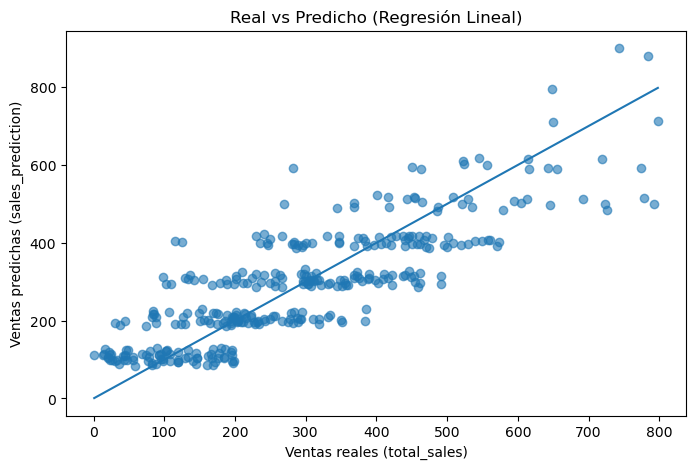

In [43]:
import matplotlib.pyplot as plt

tmp = df.dropna(subset=['sales_prediction'])  # solo filas con predicción
plt.figure(figsize=(8,5))
plt.scatter(tmp['total_sales'], tmp['sales_prediction'], alpha=0.6)
xmin, xmax = tmp['total_sales'].min(), tmp['total_sales'].max()
plt.plot([xmin, xmax], [xmin, xmax])  # línea ideal y=x
plt.xlabel("Ventas reales (total_sales)")
plt.ylabel("Ventas predichas (sales_prediction)")
plt.title("Real vs Predicho (Regresión Lineal)")
plt.show()


In [47]:
# --- Análisis por producto (paralelo al global) ---
ventas_prod_daily = (
    ventas
    .groupby(['date','product_id','product','category'], as_index=False)
    .agg(
        total_sales=('sales','sum'),
        avg_price=('price','mean'),
        txns=('product_id','count')
    )
)


print("Ventas por producto (head):")
print(ventas_prod_daily.head(30))


Ventas por producto (head):
         date  product_id      product    category  total_sales  avg_price  \
0  2024-08-28         709  Impermeable   Chaquetas          181     177.02   
1  2024-08-28         814      bufanda   Chaquetas          146      29.08   
2  2024-08-28         960       poncho   Chaquetas           71     187.65   
3  2024-08-29           6        botas  accesorios           20     160.85   
4  2024-08-30         221       poncho   Chaquetas           51     148.52   
5  2024-08-30         326     chaqueta   Chaquetas           68      86.75   
6  2024-08-30         611      bufanda   Chaquetas          131     115.61   
7  2024-08-30         662        botas   Chaquetas          130      87.58   
8  2024-08-30         923       poncho   Chaquetas          171      65.17   
9  2024-08-30         984     chaqueta   Chaquetas          168      35.94   
10 2024-08-31         135     chaqueta     calzado           43      51.07   
11 2024-08-31         466      guant